In [55]:
import pandas as pd
import yaml
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes
from IPython.core.display_functions import display
from src.data_cleaning import prepare_data
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.preprocessing import KBinsDiscretizer
from itertools import product

In [18]:
# figure settings
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

sns.set_theme(style="whitegrid")
sns.set_palette(palette="Paired")

# set seed
np.random.seed(42)

# Get Data

In [ ]:
config = yaml.safe_load(open('../../configs/config.yml'))

In [ ]:
def get_data(config=config):
    # get paths
    paths = config.get('paths', 'NO "PATHS" SET IN CONFIG')

    # read
    x_train = pd.read_csv("../../" + paths.get('train_values'))
    y_train = pd.read_csv("../../" + paths.get('train_labels'))

    # join
    df_train = pd.merge(x_train, y_train, on="building_id")

    return df_train

In [ ]:
%%time
train = get_data(config)

In [ ]:
train.info()

In [ ]:
binary_encoded_cols = [x for x in train.columns if x.startswith("has_")]
columns_to_ignore = ["building_id", "geo_level_1_id", "geo_level_2_id", "geo_level_3_id", "damage_grade", "count_floors_pre_eq", "count_families"]

In [ ]:
# Dataframe without outliers
train = prepare_data(df=train, config=config, ignore_cols=columns_to_ignore+binary_encoded_cols, outlier_method="replace")

In [ ]:
train.info()

In [ ]:
len(train.columns.tolist())

In [ ]:
len(set(train.columns.tolist()))

# Objective
1. Apply Feature discretization which decomposes each feature into a set of bins. The discrete values are then one-hot encoded. **Benefit:** Reduce Noise, Feature value might be more intuitive, minimize outlier influence (not applying to our use case since we are doing an outlier handling either ways)
2. Try Clustering to reduce dimensions and value the impact of the combination of different features. **Benefit:** Build new features replace others taking their impact on different features into account, also reduce dimension.

**Warning:** Keep in mind that in both cases there is without a doubt an Information Loss

In [ ]:
def plot_bins(values):
    """visualizes the number of observations in each bin"""

    sns.countplot(values)
    plt.xlabel('Bins')
    plt.ylabel('Frequency')
    plt.show()

def show_bins(bins):
    """Shows the ranges of values the bins comprises"""

    for i in range(len(bins)-1):
        print(f'Bin {i}: {str(bins[i])} -> {str(bins[i+1])}')

# Clustering of features 'geo_level'
Using k-modes clustering to discretize the categorical "geo_level_x_id" feature of the data based on the categorical "damage_grade" feature.

In [ ]:
df = train[["geo_level_1_id", "geo_level_2_id", "geo_level_3_id", "damage_grade"]].copy()
#display(df.size)
#df.drop_duplicates(inplace=True)
df = df.astype('category')
#display(df.size)
df.info()

In [ ]:
cluster_cols = ["damage_grade", "geo_level_1_id"]

In [ ]:
%%time
# Perform k-modes clustering with 5 clusters
kmodes = KModes(n_clusters=5, init='Huang', n_init=5, verbose=1).fit(df[cluster_cols])
# Add cluster labels to dataframe
tmp = df.copy()
tmp['cluster'] = kmodes.labels_

Run 3, iteration: 1/100, moves: 2576, cost: 216588.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 3987, cost: 265885.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 11149, cost: 200310.0
Best run was number 5
CPU times: total: 4min 31s
Wall time: 4min 36s


Create a visualization to compare the original and clustered data:

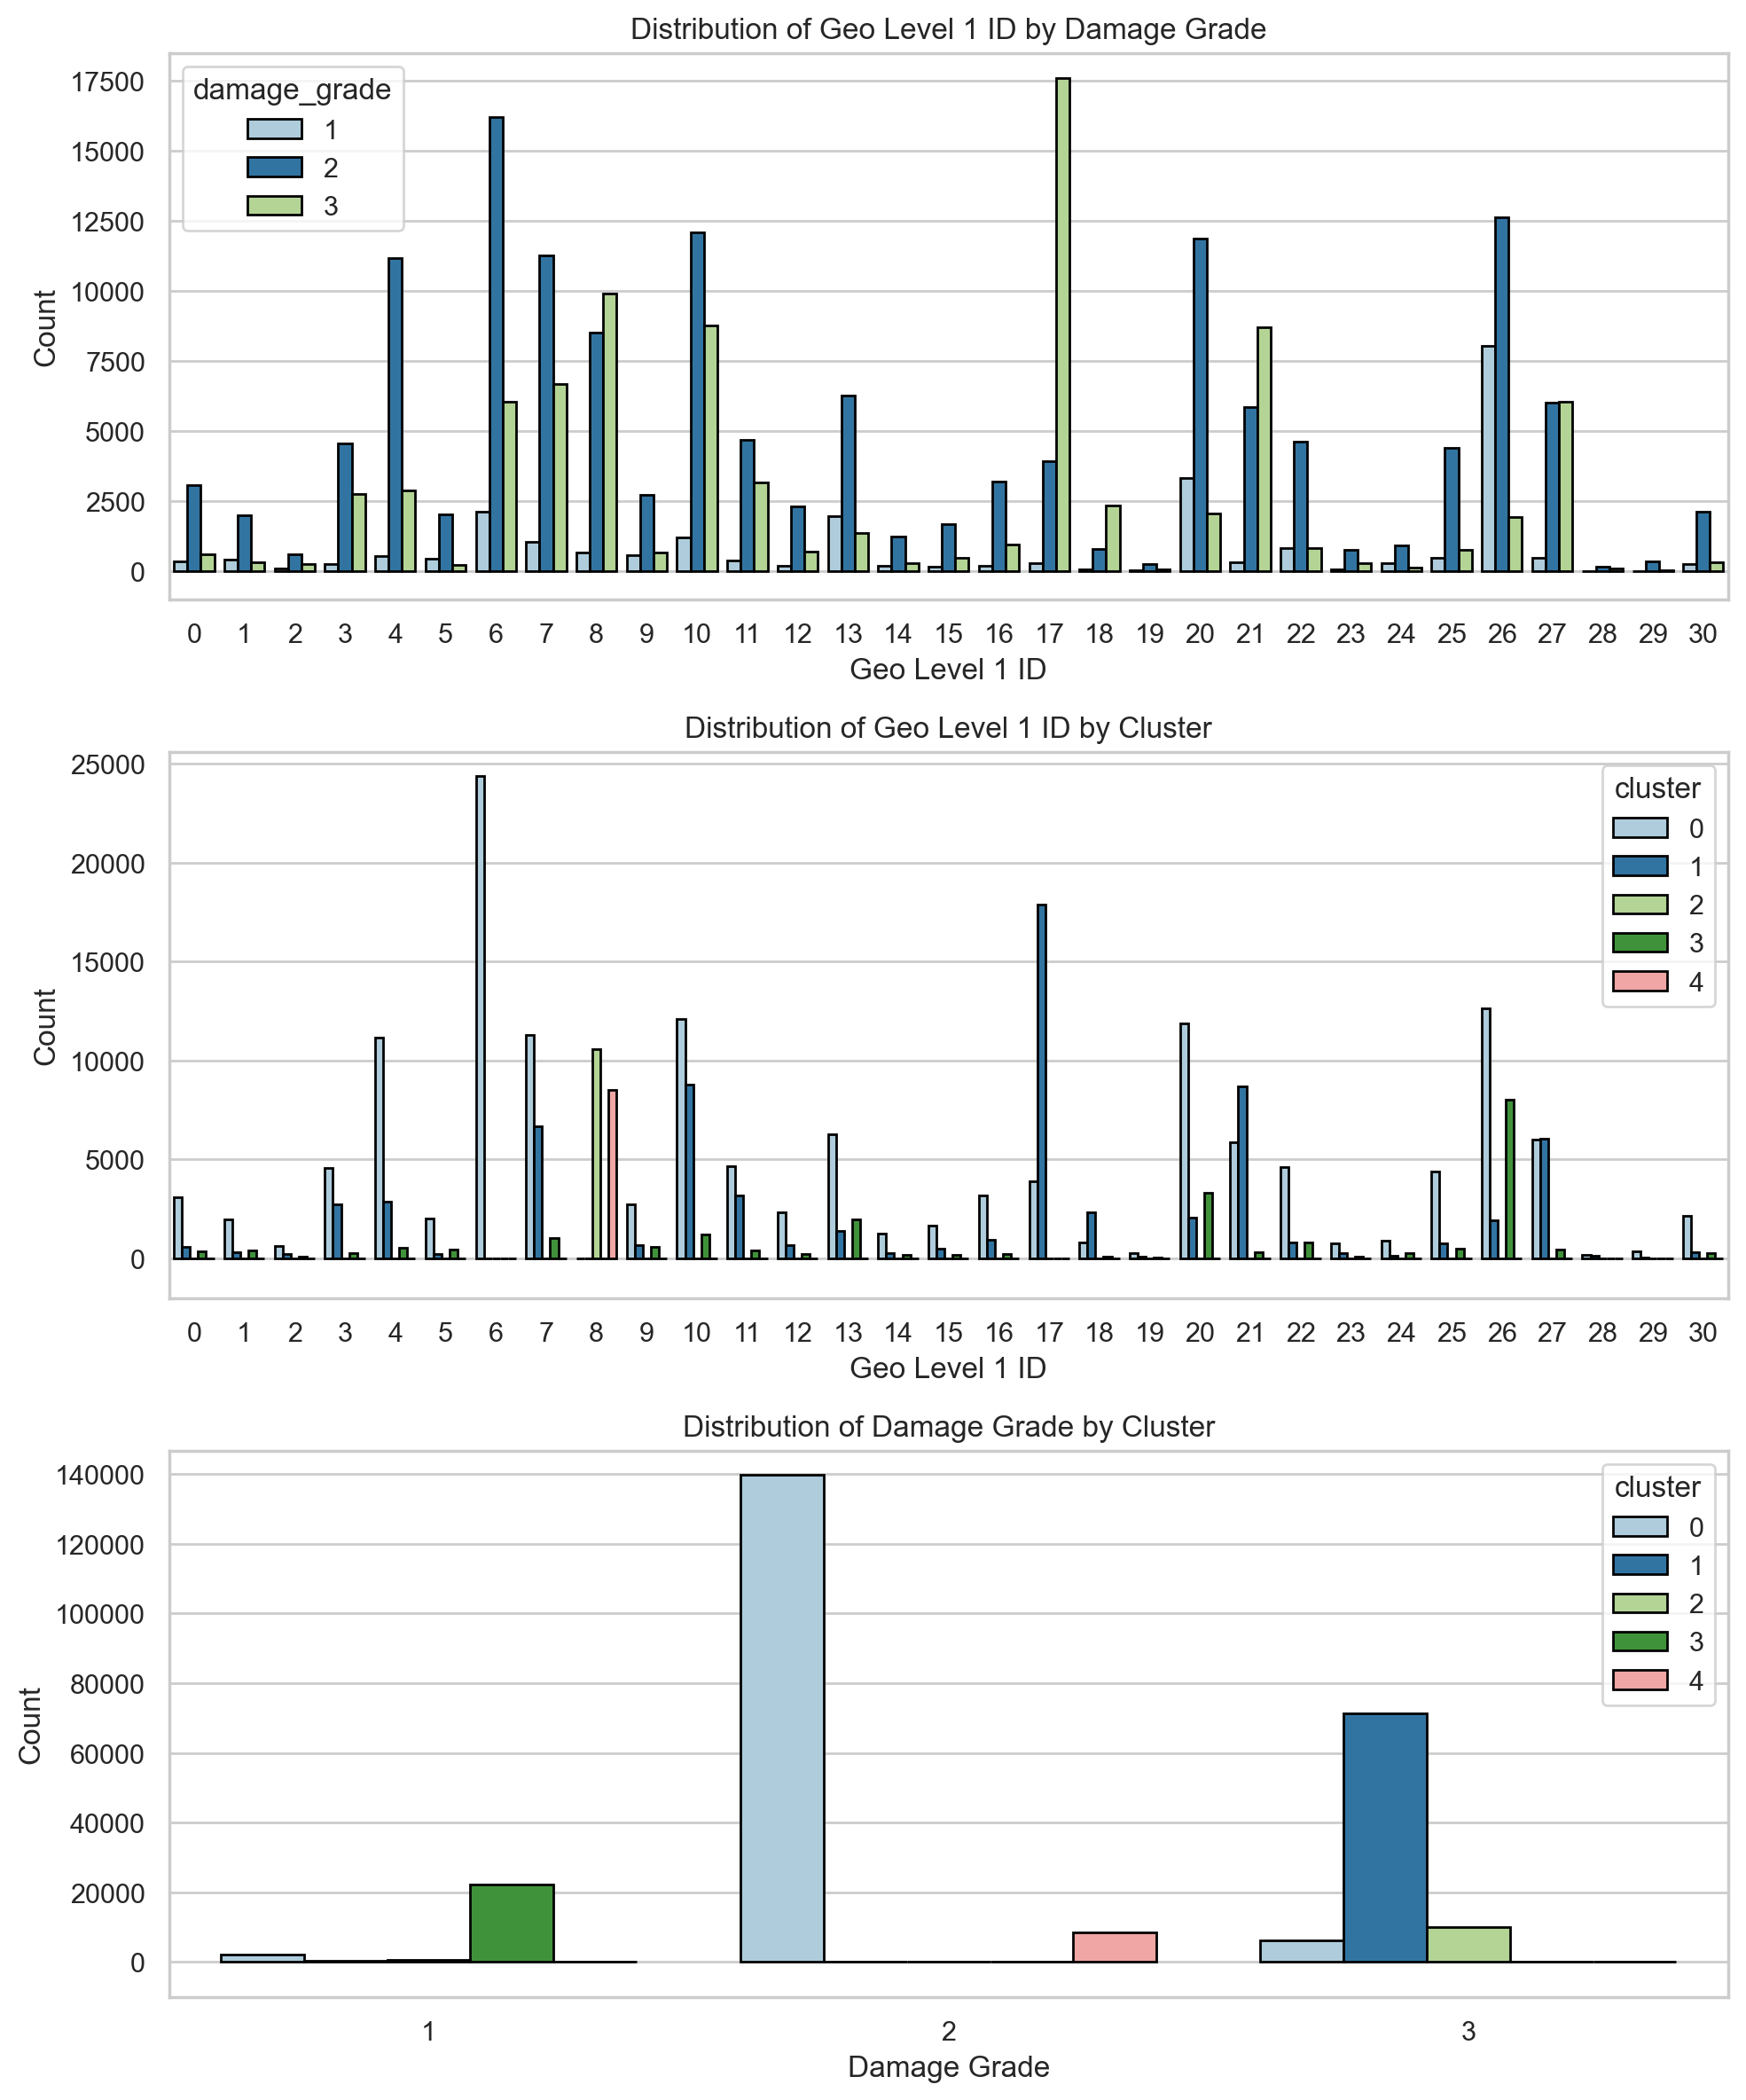

CPU times: total: 3.19 s
Wall time: 3.32 s


In [52]:
%%time
# Create plot
fig, axes = plt.subplots(nrows=3, figsize=(10,12))

sns.countplot(data=tmp, x='geo_level_1_id', hue='damage_grade', ax=axes[0], edgecolor='black')
axes[0].set_xlabel('Geo Level 1 ID')
axes[0].set_ylabel('Count')
axes[0].set_title('Distribution of Geo Level 1 ID by Damage Grade')
axes[0].set_ylim(-1000)

sns.countplot(data=tmp, x='geo_level_1_id', hue='cluster', ax=axes[1], edgecolor='black')
axes[1].set_xlabel('Geo Level 1 ID')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Geo Level 1 ID by Cluster')
axes[1].set_ylim(-2000)

sns.countplot(data=tmp, x='damage_grade', hue='cluster', ax=axes[2], edgecolor='black')
axes[2].set_xlabel('Damage Grade')
axes[2].set_ylabel('Count')
axes[2].set_title('Distribution of Damage Grade by Cluster')
axes[2].set_ylim(-10000)

plt.tight_layout()
plt.show()

**Findings:** The plots are showing the original distribution of "geo_level_1_id" by damage grade on the top, the clustered distribution of "geo_level_1_id" by cluster in the middle and finally the distribution of "damage_grade" by cluster at the bottom. No significant trend can be found.

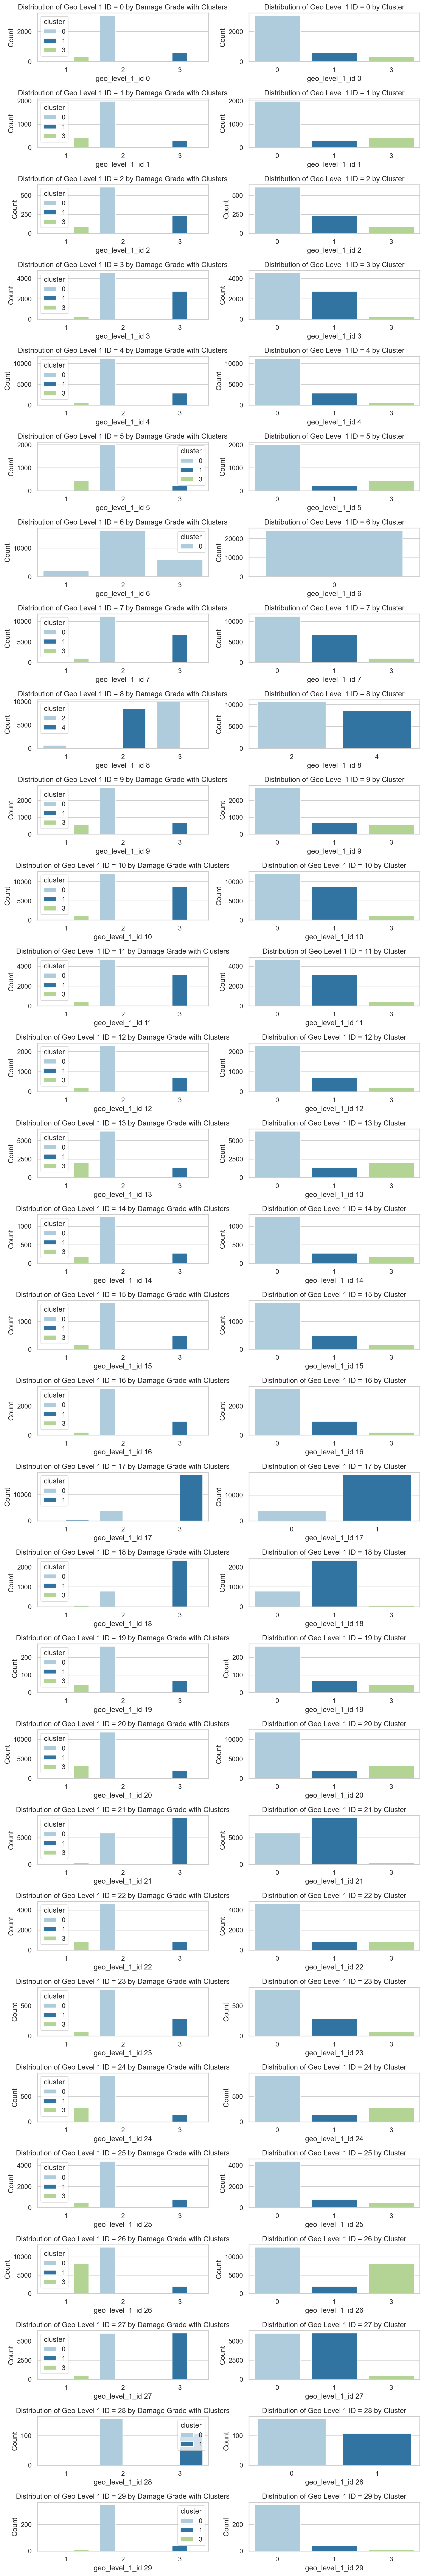

In [58]:
# Print a more detailed version
fig, axes = plt.subplots(figsize=(10, 60), nrows=30, ncols=2)
axes = axes.flatten()
sub_axes = [axes[i:i+2] for i in range(0, len(axes), 2)]

for geo_level, sub_ax in zip(list(range(30)), sub_axes):
    data_filtered = tmp[tmp['geo_level_1_id'] == geo_level]
    data_filtered.reset_index()

    sns.countplot(data=data_filtered, x='damage_grade', hue='cluster', ax=sub_ax[0])
    sub_ax[0].set_xlabel(f'geo_level_1_id {geo_level}')
    sub_ax[0].set_ylabel('Count')
    sub_ax[0].set_title(f'Distribution of Geo Level 1 ID = {geo_level} by Damage Grade with Clusters')

    sns.countplot(data=data_filtered, x='cluster', ax=sub_ax[1])
    sub_ax[1].set_xlabel(f'geo_level_1_id {geo_level}')
    sub_ax[1].set_ylabel('Count')
    sub_ax[1].set_title(f'Distribution of Geo Level 1 ID = {geo_level} by Cluster')

plt.tight_layout()
plt.show()

# Discretization of feature 'age' in bins

In [59]:
df = train.copy()

#### Equal-Frequency Discretization
Use the scikit-learn package’s KBinsDiscretizer, where the strategy hyperparameter is set to ‘quantile’.


In [ ]:
%%time
# create discretizer
kbins = KBinsDiscretizer(n_bins=5, strategy='quantile', encode='ordinal', subsample=200000, random_state=42)
age_bin = kbins.fit_transform(np.array(df['age']).reshape(-1,1))

# show results
plot_bins(age_bin.astype(int).tolist())
show_bins(kbins.bin_edges_[0])

#### Equal-Width Discretization
1. Use the pd.cut function to encode the "age" feature into 5 equally sized bins.


In [ ]:
# Encode age column into equally sized bins
df['age_bin'] = pd.cut(df['age'], bins=5)

In [ ]:
# Create plot
fig, axes = plt.subplots(ncols=2, figsize=(12,6))

sns.kdeplot(data=df, x='age', color='blue', alpha=0.5, ax=axes[0])
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Density')
axes[0].set_title('Distribution of Age Before Binning')

sns.countplot(data=df, x='age_bin', color='orange', ax=axes[1])
axes[1].set_xlabel('Age Bin')
axes[1].set_ylabel('Count')
axes[1].set_title('Distribution of Age After Binning')

plt.tight_layout()
plt.show()

2. Transform into bins with the same width. Use this technique with the sci-kit learn package’s KBinsDiscretizer. However, the strategy hyperparameter should be set to ‘uniform’m.

In [ ]:
%%time
# create discretizer
kbins = KBinsDiscretizer(n_bins=5, strategy='uniform', encode='ordinal')
age_bin = kbins.fit_transform(np.array(df['age']).reshape(-1,1))

# show results
plot_bins(age_bin.astype(int).tolist())
show_bins(kbins.bin_edges_[0])

#### K-Means Discretization
Uusing the k-means clustering algorithm to assign data points to bins. also using scikit-learn package’s KBinsDiscretizer, however the strategy hyperparameter is set to ‘kmeans’.

In [ ]:
%%time
# create discretizer
kbins = KBinsDiscretizer(n_bins=5, strategy='kmeans', encode='ordinal')
age_bin = kbins.fit_transform(np.array(df['age']).reshape(-1,1))

# show results
plot_bins(age_bin.astype(int).tolist())
show_bins(kbins.bin_edges_[0])

**Fndings:**
* Since the column age is the only true numeric feature available, and it is possible that also a very little difference in the age meaning a difference of only 2 years can highly infect the damage grade as seen on previous plots during the EDA we decided to leave it as it is and do not apply a discretion on it.
* Added to that the range of the feature age is not as widespread as it was before since we already applied an outlier handling method on it which introduces a upper limit less than 100 years.
* The dataset heavenly depends on categorical encoded data already using different kind of bins/categories which has to be encoded (OneHot Encoding). In order to reduce the dimensions which would be increased by using bins for age due to OHE (One Hot Encoding) we also prefer to leave the age as a numerical feature